python 3.13.3

In [1]:
!pip install cvxpy
!pip install scipy
# !pip install ucimlrepo
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install ecos


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
import cvxpy as cp


In [3]:
df_agg = pd.read_csv('salesdata_uci.csv')

=== Compare JOINT vs INDEPENDENT ===
N weeks: 52 | m SKUs: 50 | keep_prob: 0.7 | q: 36
delta_joint: 0.4255 | delta_mode(single): per_series
RMSE missing  | joint: 7.444 | indep: 9.054
RMSE full     | joint: 4.13 | indep: 5.023


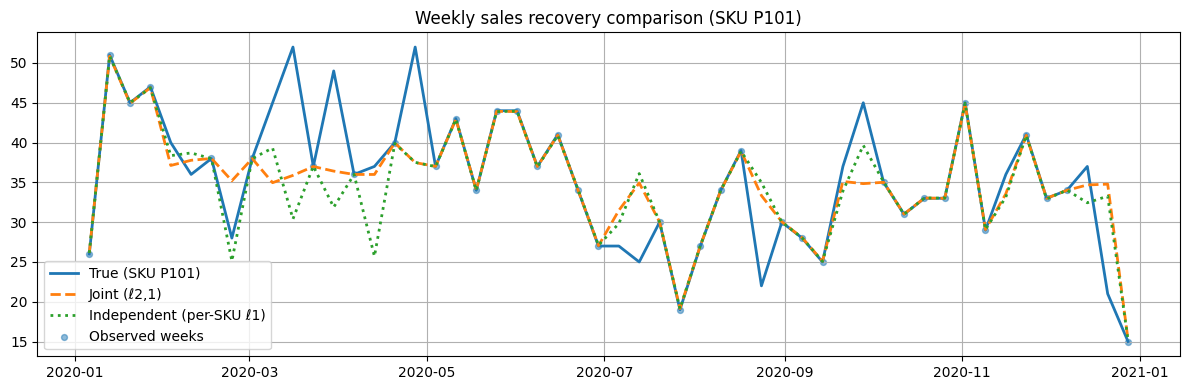

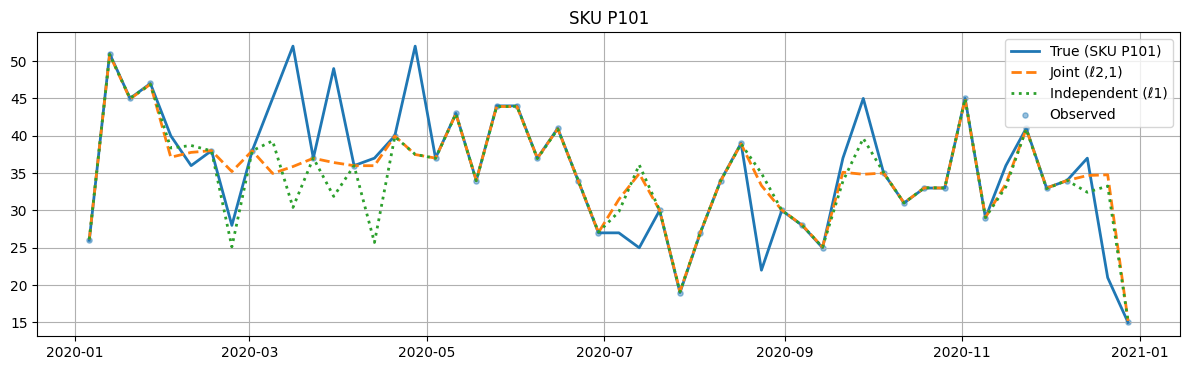

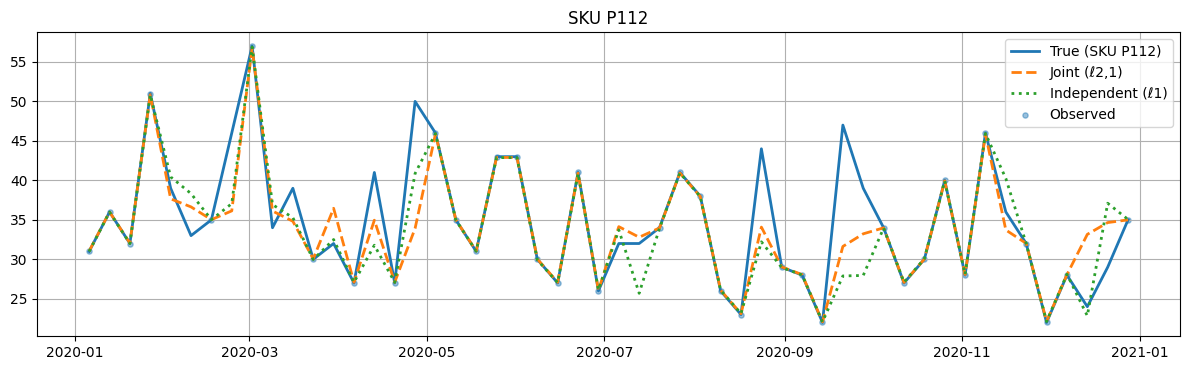

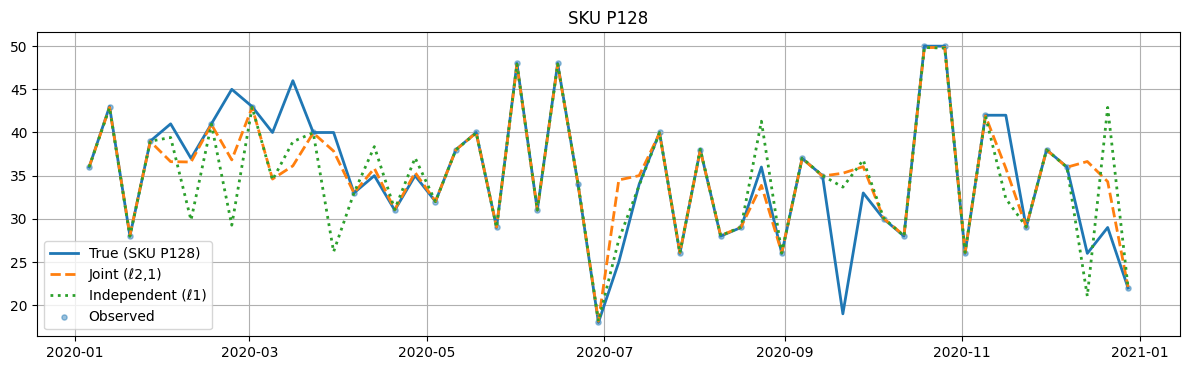

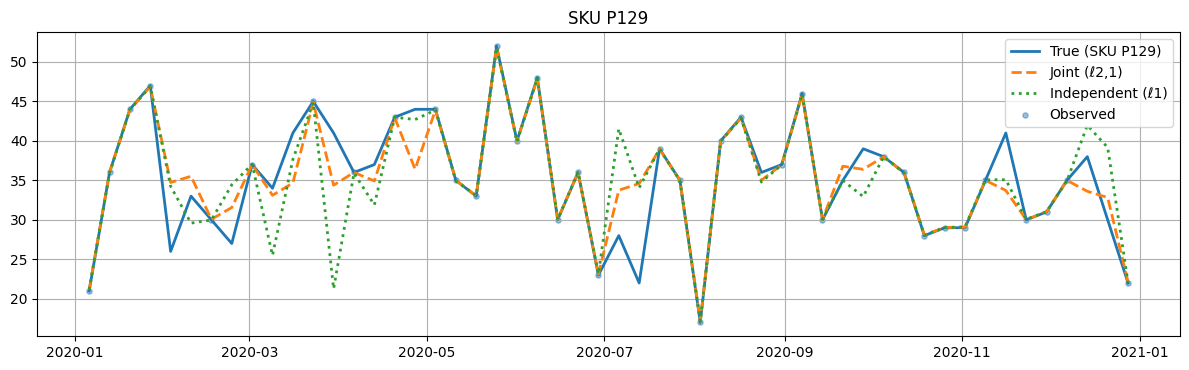

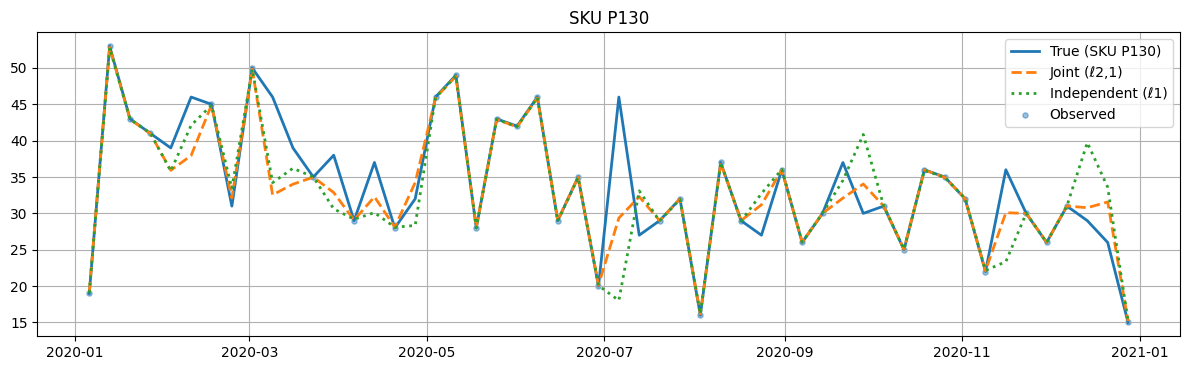

In [4]:


# ============================================================
# 1) DCT basis
# ============================================================
def build_dct_basis(N: int) -> np.ndarray:
    I = np.eye(N)
    return fftpack.dct(I, type=2, norm="ortho", axis=0)


# ============================================================
# 2a) Joint group-sparse recovery (shared-support)
#     min_C sum_k ||C[k,:]||_2  s.t. ||A C - Y||_F <= delta
# ============================================================
def recover_group_sparse_with_l2_constraint(
    A: np.ndarray,
    Y: np.ndarray,
    delta: float,
    solver: str = "SCS",
) -> np.ndarray:
    q, N = A.shape
    m = Y.shape[1]
    C = cp.Variable((N, m))

    obj = cp.Minimize(cp.sum(cp.norm(C, 2, axis=1)))  # l2,1
    cons = [cp.norm(A @ C - Y, "fro") <= delta]
    prob = cp.Problem(obj, cons)

    if solver.upper() == "ECOS":
        prob.solve(solver=cp.ECOS, verbose=False)
    else:
        prob.solve(solver=cp.SCS, max_iters=5000, eps=1e-4, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"CVXPY failed (joint): {prob.status}")

    return np.asarray(C.value)


# ============================================================
# 2b) Independent per-series SOCP (single vector)
#     min_c ||c||_1  s.t. ||A c - y||_2 <= delta_j
# ============================================================
def recover_l1_with_l2_constraint_single(
    A: np.ndarray,
    y: np.ndarray,
    delta: float,
    solver: str = "ECOS",
) -> np.ndarray:
    N = A.shape[1]
    c = cp.Variable(N)

    obj = cp.Minimize(cp.norm1(c))
    cons = [cp.norm2(A @ c - y) <= float(delta)]
    prob = cp.Problem(obj, cons)

    try:
        if solver.upper() == "ECOS":
            prob.solve(solver=cp.ECOS, verbose=False)
        else:
            prob.solve(solver=cp.SCS, max_iters=5000, eps=1e-4, verbose=False)
    except Exception:
        # robust fallback
        prob.solve(solver=cp.SCS, max_iters=8000, eps=1e-4, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"CVXPY failed (single): {prob.status}")

    return np.asarray(c.value)


# ============================================================
# 3) Make weekly matrix F (weeks x SKU)
# ============================================================
def make_weekly_matrix(df_agg: pd.DataFrame, m: int = 10, sku_list=None):
    d = df_agg.copy()
    d["week_start"] = pd.to_datetime(d["week_start"])

    if sku_list is None:
        sku_list = (
            d.groupby("SKU_NO")["sales"]
             .sum()
             .sort_values(ascending=False)
             .head(m)
             .index.tolist()
        )
    else:
        sku_list = list(sku_list)
        m = len(sku_list)

    F = (d[d["SKU_NO"].isin(sku_list)]
         .pivot_table(index="week_start", columns="SKU_NO", values="sales", aggfunc="sum")
         .sort_index())

    full_index = pd.date_range(F.index.min(), F.index.max(), freq="W-MON")
    F = F.reindex(full_index).fillna(0.0)

    return F, sku_list


# ============================================================
# 4) Compare JOINT vs INDEPENDENT on real data + plot both
# ============================================================
def run_joint_vs_independent_on_real_sales(
    df_agg: pd.DataFrame,
    m: int = 10,
    sku_list=None,
    keep_prob: float = 0.7,
    q: int | None = None,
    delta_rel: float = 1e-2,
    delta_mode: str = "per_series",   # "per_series" or "shared_div_sqrtm"
    seed: int = 0,
    solver_joint: str = "SCS",
    solver_single: str = "ECOS",
    plot_sku_idx: int = 0,
    plot_compare_top_k: int = 5,      # plot first K SKUs too
):
    # ---- 1) weekly matrix
    F_df, sku_list = make_weekly_matrix(df_agg, m=m, sku_list=sku_list)
    X_full = F_df.values.astype(float)      # (N, m)
    N, m = X_full.shape

    # ---- 2) standardize per SKU (stability)
    mu = X_full.mean(axis=0, keepdims=True)
    sd = X_full.std(axis=0, keepdims=True)
    sd = np.where(sd == 0, 1.0, sd)
    X = (X_full - mu) / sd

    # ---- 3) common missing weeks mask
    rng = np.random.default_rng(seed)
    mask_t = rng.random(N) < keep_prob
    X_obs = X.copy()
    X_obs[~mask_t, :] = np.nan

    valid = np.where(mask_t)[0]
    if q is None:
        q = min(len(valid), max(20, int(0.8 * len(valid))))
    q = min(q, len(valid))

    obs_idx = rng.choice(valid, size=q, replace=False)
    obs_idx.sort()

    Y = X_obs[obs_idx, :]              # (q, m)
    B = build_dct_basis(N)             # (N, N)
    A = B[obs_idx, :]                  # (q, N)

    # ---- 4) deltas
    delta_joint = float(delta_rel * np.linalg.norm(Y, "fro"))
    if delta_mode == "shared_div_sqrtm":
        # heuristic: split Fro bound across m columns
        delta_single_all = delta_joint / np.sqrt(m)
    else:
        delta_single_all = None  # per-series

    # ---- 5) JOINT recovery
    C_joint = recover_group_sparse_with_l2_constraint(A, Y, delta=delta_joint, solver=solver_joint)
    X_joint = B @ C_joint

    # ---- 6) INDEPENDENT recovery (solve m SOCPs)
    C_ind = np.zeros((N, m), dtype=float)
    for j in range(m):
        yj = Y[:, j]
        if delta_single_all is not None:
            dj = float(delta_single_all)
        else:
            dj = float(delta_rel * np.linalg.norm(yj))  # per-series bound

        cj = recover_l1_with_l2_constraint_single(A, yj, delta=dj, solver=solver_single)
        C_ind[:, j] = cj

    X_ind = B @ C_ind

    # ---- 7) unscale back to sales
    X_joint_full = np.clip(X_joint * sd + mu, 0, None)
    X_ind_full   = np.clip(X_ind   * sd + mu, 0, None)

    # ---- 8) metrics (missing weeks)
    miss = ~mask_t
    rmse_joint_missing = float(np.sqrt(np.mean((X_joint_full[miss, :] - X_full[miss, :]) ** 2)))
    rmse_ind_missing   = float(np.sqrt(np.mean((X_ind_full[miss, :]   - X_full[miss, :]) ** 2)))

    rmse_joint_full = float(np.sqrt(np.mean((X_joint_full - X_full) ** 2)))
    rmse_ind_full   = float(np.sqrt(np.mean((X_ind_full   - X_full) ** 2)))

    print("=== Compare JOINT vs INDEPENDENT ===")
    print(f"N weeks: {N} | m SKUs: {m} | keep_prob: {keep_prob} | q: {q}")
    print(f"delta_joint: {delta_joint:.4g} | delta_mode(single): {delta_mode}")
    print(f"RMSE missing  | joint: {rmse_joint_missing:.4g} | indep: {rmse_ind_missing:.4g}")
    print(f"RMSE full     | joint: {rmse_joint_full:.4g} | indep: {rmse_ind_full:.4g}")

    # ---- 9) plot chosen SKU with both reconstructions
    dates = F_df.index
    j = int(plot_sku_idx)
    sku = F_df.columns[j]

    plt.figure(figsize=(12, 4))
    plt.plot(dates, X_full[:, j], label=f"True (SKU {sku})", linewidth=2)
    plt.plot(dates, X_joint_full[:, j], "--", label="Joint (ℓ2,1)", linewidth=2)
    plt.plot(dates, X_ind_full[:, j], ":", label="Independent (per-SKU ℓ1)", linewidth=2)
    plt.scatter(dates[mask_t], X_full[mask_t, j], s=18, alpha=0.5, label="Observed weeks")
    plt.title(f"Weekly sales recovery comparison (SKU {sku})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 10) optional: plot first K SKUs
    K = min(plot_compare_top_k, m)
    for jj in range(K):
        sku_j = F_df.columns[jj]
        plt.figure(figsize=(12, 3.8))
        plt.plot(dates, X_full[:, jj], label=f"True (SKU {sku_j})", linewidth=2)
        plt.plot(dates, X_joint_full[:, jj], "--", label="Joint (ℓ2,1)", linewidth=2)
        plt.plot(dates, X_ind_full[:, jj], ":", label="Independent (ℓ1)", linewidth=2)
        plt.scatter(dates[mask_t], X_full[mask_t, jj], s=14, alpha=0.45, label="Observed")
        plt.title(f"SKU {sku_j}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "F_df": F_df,
        "sku_list": sku_list,
        "mask_t": mask_t,
        "obs_idx": obs_idx,
        "X_full": X_full,
        "X_joint_full": X_joint_full,
        "X_ind_full": X_ind_full,
        "rmse_joint_missing": rmse_joint_missing,
        "rmse_ind_missing": rmse_ind_missing,
        "rmse_joint_full": rmse_joint_full,
        "rmse_ind_full": rmse_ind_full,
    }


# =========================
# Example usage:
# =========================
res = run_joint_vs_independent_on_real_sales(
    df_agg,
    m=50,
    keep_prob=0.7,
    q=200,
    delta_rel=1e-2,
    delta_mode="per_series",       # or "shared_div_sqrtm"
    seed=0,
    solver_joint="ECOS",            # or "ECOS"
    solver_single="ECOS",          # or "SCS"
    plot_sku_idx=0,
    plot_compare_top_k=5
)


In [ ]:
!pip install cvxpy

  Using cached osqp-1.0.5-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
  Using cached clarabel-0.11.1-cp39-abi3-win_amd64.whl.metadata (4.9 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 7.7 MB/s  0:00:00
Using cached clarabel-0.11.1-cp39-abi3-win_amd64.whl (887 kB)
Using cached osqp-1.0.5-cp313-cp313-win_amd64.whl (310 kB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   --------------------- ------------------ 3.9/7.5 MB 30.4 MB/s eta 0:00:01
   ---------------------------------------  7.3/7.5 MB 29.1 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 14.9 MB/s  0:00:00

   ---------------------------------------- 0/4 [scs]
   ---------- ----------------------------- 1/4 [osqp]
   ---------- ----------------------------- 1/4 [osqp]
   ---------- ----------------------------- 1/4 [osqp]
   ---------- ----------------------------- 1/4 [osqp]
   ---------- --------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
